## Loading and sampling multiple edge-types
- Extension of notebook 3 and 4 in same repo
- PyG 2.2.0 tagged version https://github.com/pyg-team/pytorch_geometric/tree/2.2.0

In [5]:
import torch
from torch import Tensor
print(torch.__version__)

import pandas as pd
from torch_geometric.data import download_url, extract_zip

import pandas as pd

from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

# note it uses the wrong linkNeighborLoader (there are two). one for sampler and one for loader.
from torch_geometric.loader import LinkNeighborLoader


1.13.1


In [6]:
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import NeighborLoader
from torch_sparse import SparseTensor

# we actually doen't need this if we just use hetero data, also have graph_store interface. 
def add_date_to_graph_store(graph_store,data):
    for edge_type in train_data.edge_types: 
        edge_index = data[edge_type].edge_index
        coo = (edge_index[0], edge_index[1])
        graph_store_train.put_edge_index(edge_index = coo,
                            edge_type = edge_type,
                            layout = 'coo',
                            size = (feature_store[edge_type[0]].num_nodes, feature_store[edge_type[2]].num_nodes)
                            )

In [35]:
## Drawing helper functions

import networkx as nx
import seaborn as sns # only used for color_palette

def graph_from_hetero(data):
    G = nx.Graph()
    node_lookup = {}
    for node in data.node_types:
        node_lookup[node] = data[node].node_id.tolist()
        G.add_nodes_from([node+str(i) for i in data[node].node_id.tolist()],node_type=node)
 

    for edge_type in data.edge_types:
        links = data[edge_type]["edge_index"].tolist()   
        link_list = [(edge_type[0]+str(node_lookup[edge_type[0]][i])
                      ,edge_type[2]+str(node_lookup[edge_type[2]][j])) for i,j in zip(*links)] 
        G.add_edges_from(link_list)
 
    return G

def sub_graph_from_nodes(G,nodes=None):
    if nodes:
        return G.edge_subgraph([i for i in list(G.edges) if (n in i for n in nodes)])
    return G




def draw_multi_node(G):
    
    node_types = set([y["node_type"] for x,y in G.nodes(data=True) if "node_type" in y.keys()])
    
    palette = sns.color_palette(None, len(node_types))
    
    pos = nx.spring_layout(G, seed=0)  # positions for all nodes

    for i,node_type in enumerate(node_types):
        # Assumes that no node name is a subset of other node name.
        nodes = [x for x in G.nodes() if node_type in x]
        # Somehow there is a lot of notes without links
        #nodes = [x for x,y in G.nodes(data=True) if "node_type" in y.keys() and y['node_type']==node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[palette[i]],node_size=40)
        nx.draw_networkx_edges(G,pos,alpha=.6)
    nx.draw_networkx_labels(G,pos,alpha=.5,font_size=10)


def quick_draw(data,sub_nodes=None):
    G = graph_from_hetero(data)
    subG = sub_graph_from_nodes(G,sub_nodes)
    draw_multi_node(subG)

In [8]:

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [9]:
print('movies.csv:')
print('===========')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head())
print()
print('ratings.csv:')
print('============')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head())

movies.csv:
   movieId                                       genres
0        1  Adventure|Animation|Children|Comedy|Fantasy
1        2                   Adventure|Children|Fantasy
2        3                               Comedy|Romance
3        4                         Comedy|Drama|Romance
4        5                                       Comedy

ratings.csv:
   userId  movieId
0       1        1
1       1        3
2       1        6
3       1       47
4       1       50


In [10]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


In [11]:
# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)


Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        3         1
2        6         2
3       47         3
4       50         4

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


### Create random user links as well 
(we want to work with multiple link types)

In [12]:
n_user_links = 2000

import numpy as np
user_to_user = np.random.choice(unique_user_id.mappedID.values, size=(n_user_links,2), replace=True, p=None)

edge_index_user_to_user = torch.stack((torch.from_numpy(user_to_user[:,0])
                                    ,torch.from_numpy(user_to_user[:,1])),dim=0)
edge_index_user_to_user

tensor([[549,  94, 105,  ..., 579, 244, 379],
        [201, 374, 403,  ..., 230, 183, 576]])

In [13]:

data = HeteroData()

## Keep data object to only transform it to the graph store after transformation
## but omit adding the feature vectors of movies.
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices:
# data["movie"].x = movie_feat # TODO
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie  
data["user", "likes", "user"].edge_index = edge_index_user_to_user 

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:

# TODO:
# FROM HERE https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html
transform = T.Compose([T.ToUndirected()])
data = transform(data)          

feature_store = HeteroData()

# Add the data to the feature store
feature_store.put_tensor(movie_feat, group_name='movie', attr_name='x', index=torch.arange(len(movies_df)))
feature_store.put_tensor(torch.arange(len(movies_df)), group_name='movie', attr_name='node_id', index=torch.arange(len(movies_df)))


# TODO: Is there a way to add a feature with only id to the feature store? 
feature_store.put_tensor(torch.arange(len(unique_user_id)),group_name='user', attr_name='node_id', index=torch.arange(len(unique_user_id)))


## Delay adding graph to graph store after linksplits 
## Add graph to graph store

#graph_store = HeteroData()
# coo = (edge_index_user_to_movie[0], edge_index_user_to_movie[1])

# graph_store.put_edge_index(edge_index=coo,
#                            edge_type=('user', 'rates', 'movie'),
#                            layout='coo', size=(len(coo[0]),len(coo[1])) )

# # put reverse index
# graph_store.put_edge_index(edge_index=coo[::-1],
#                            edge_type=('movie', 'rev_rates', 'user'),
#                            layout='coo', size=(len(coo[1]),len(coo[0])) )


print(data)

assert data.node_types == ["user", "movie"]
assert data.edge_types == [("user", "rates", "movie"),
                           ("user","likes","user"),
                           ("movie", "rev_rates", "user"),
                           ]
assert data["user"].num_nodes == 610
assert data["user"].num_features == 0
assert data["movie"].num_nodes == 9742
#assert data["movie"].num_features == 20
assert data["user", "rates", "movie"].num_edges == 100836
assert data["movie", "rev_rates", "user"].num_edges == 100836
#assert data["user", "likes", "user"].num_edges == 200

HeteroData(
  user={ node_id=[610] },
  movie={ node_id=[9742] },
  (user, rates, movie)={ edge_index=[2, 100836] },
  (user, likes, user)={ edge_index=[2, 3980] },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


In [14]:
transform = T.RandomLinkSplit(
    num_val=0.1, 
    num_test=0.1,  
    disjoint_train_ratio=.3,  
    neg_sampling_ratio=2,  
    add_negative_train_samples=False,  
    edge_types=[("user", "rates", "movie"),("user","likes","user")],
    rev_edge_types=[("movie", "rev_rates", "user"),("user","likes","user")], 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)


## Not needed. The data itself can work as the graph store. 
# train_graph_store = HeteroData()
# add_date_to_graph_store(train_graph_store, train_data)


assert train_data["user", "rates", "movie"].num_edges == 56469
assert train_data["user", "rates", "movie"].edge_label_index.size(1) == 24201
assert train_data["movie", "rev_rates", "user"].num_edges == 56469
# No negative edges added:
assert train_data["user", "rates", "movie"].edge_label.min() == 1
assert train_data["user", "rates", "movie"].edge_label.max() == 1

assert val_data["user", "rates", "movie"].num_edges == 80670
assert val_data["user", "rates", "movie"].edge_label_index.size(1) == 30249
assert val_data["movie", "rev_rates", "user"].num_edges == 80670
# Negative edges with ratio 2:1:
assert val_data["user", "rates", "movie"].edge_label.long().bincount().tolist() == [20166, 10083]

Training data:
HeteroData(
  user={ node_id=[610] },
  movie={ node_id=[9742] },
  (user, rates, movie)={
    edge_index=[2, 56469],
    edge_label=[24201],
    edge_label_index=[2, 24201]
  },
  (user, likes, user)={
    edge_index=[2, 2229],
    edge_label=[955],
    edge_label_index=[2, 955]
  },
  (movie, rev_rates, user)={ edge_index=[2, 56469] }
)

Validation data:
HeteroData(
  user={ node_id=[610] },
  movie={ node_id=[9742] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[30249],
    edge_label_index=[2, 30249]
  },
  (user, likes, user)={
    edge_index=[2, 3184],
    edge_label=[1194],
    edge_label_index=[2, 1194]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)


In [15]:
# Define seed edges:
edge_label_index = train_data[("user", "rates", "movie")].edge_label_index
edge_label = train_data[("user", "rates", "movie")].edge_label

In [62]:
# Sample only with labels for user_rate_movies
train_loader = LinkNeighborLoader(
    data=(feature_store,train_data),  # <--- Changed to feature store, graph store
    num_neighbors=[1,1],  # Original [20,10]
    neg_sampling_ratio=0,  
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=1, # Original 128
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))
sampled_data_simple = sampled_data
print("Sampled mini-batch:")
print("===================")
print(sampled_data)



Sampled mini-batch:
HeteroData(
  movie={
    num_nodes=4,
    x=[4, 20],
    node_id=[4]
  },
  user={
    num_nodes=6,
    node_id=[6]
  },
  (user, rates, movie)={
    edge_index=[2, 2],
    input_id=[1],
    edge_label_index=[2, 1],
    edge_label=[1]
  },
  (user, likes, user)={ edge_index=[2, 3] },
  (movie, rev_rates, user)={ edge_index=[2, 3] }
)


user tensor(303)
movie tensor(728)


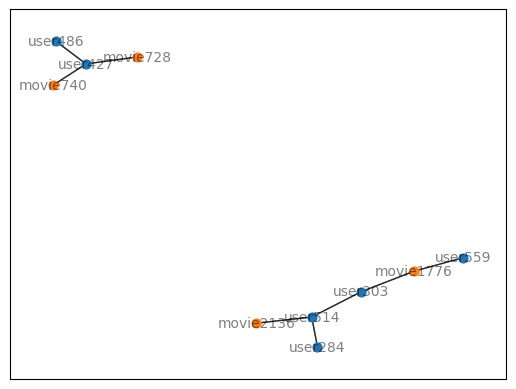

In [63]:

print("user",sampled_data["user"]["node_id"][0])
print("movie",sampled_data["movie"]["node_id"][0])

quick_draw(sampled_data)


In [101]:
# sample only for user_likes_user
user_edge_label_index = train_data[("user", "likes", "user")].edge_label_index
user_edge_label = train_data[("user", "likes", "user")].edge_label

# Sample only with labels for user_rate_movies
train_loader = LinkNeighborLoader(
    data=(feature_store,train_data),  # <--- Changed to feature store, graph store
    num_neighbors=[1,1],  # Original [20,10]
    neg_sampling_ratio=0,  
    edge_label_index=(("user","likes","user"),user_edge_label_index),
    edge_label=user_edge_label,
    batch_size=1, # Original 128
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

# assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
# assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
# assert sampled_data["user", "rates", "movie"].edge_label.max() == 1


Sampled mini-batch:
HeteroData(
  movie={
    num_nodes=4,
    x=[4, 20],
    node_id=[4]
  },
  user={
    num_nodes=7,
    node_id=[7]
  },
  (user, rates, movie)={ edge_index=[2, 2] },
  (user, likes, user)={
    edge_index=[2, 4],
    input_id=[1],
    edge_label_index=[2, 1],
    edge_label=[1]
  },
  (movie, rev_rates, user)={ edge_index=[2, 4] }
)


tensor([[0],
        [1]])
user1 tensor(123)
user2 tensor(296)


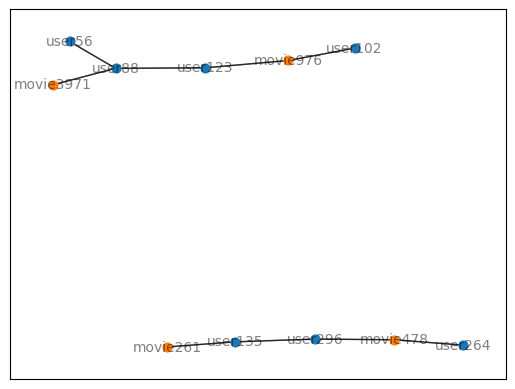

In [102]:
print(sampled_data[("user","likes","user")].edge_label_index)
print("user1",sampled_data["user"]["node_id"][0])
print("user2",sampled_data["user"]["node_id"][1])

quick_draw(sampled_data)


In [99]:
# Sample only with labels for user_rate_movies
train_loader = LinkNeighborLoader(
    data=(feature_store,train_data),  # <--- Changed to feature store, graph store
    num_neighbors={("user","rates","movie"):[10,10],("user","likes","user"):[10,10]},  # Original [20,10]
    neg_sampling_ratio=0,  
    edge_label_index=(("user","likes","user"),user_edge_label_index),
    edge_label=user_edge_label,
    batch_size=1, # Original 128
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  movie={
    num_nodes=0,
    x=[0, 20],
    node_id=[0]
  },
  user={
    num_nodes=52,
    node_id=[52]
  },
  (user, rates, movie)={ edge_index=[2, 0] },
  (user, likes, user)={
    edge_index=[2, 59],
    input_id=[1],
    edge_label_index=[2, 1],
    edge_label=[1]
  },
  (movie, rev_rates, user)={ edge_index=[2, 0] }
)


tensor([[1],
        [0]])
user1 tensor(323)
user2 tensor(446)


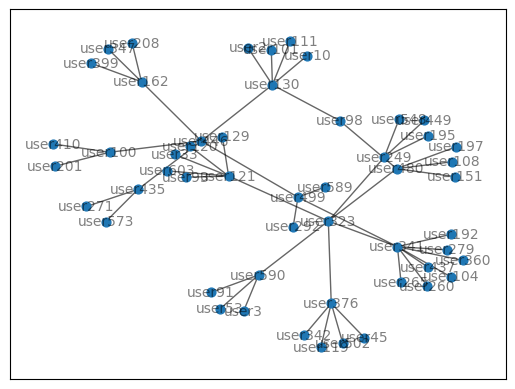

In [100]:
print(sampled_data[("user","likes","user")].edge_label_index)
print("user1",sampled_data["user"]["node_id"][0])
print("user2",sampled_data["user"]["node_id"][1])

quick_draw(sampled_data)
